## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import math

## Read Excel File

In [2]:
process_data = 'ori'

# Specify file path
if process_data == 'new':
    output_path = r"vol_anno_new.xlsx"
    file_path = r"final project\tabular data\new_data_tab_data.xlsx"
    annotations_path = r'new_data_tab_data_vol_stage_annotations.xlsx'
elif process_data == 'ori':
    output_path = r"vol_anno_ori.xlsx"
    file_path = r"final project\tabular data\tab_data_annotated_pats.xlsx"
    annotations_path = r'tab_data_annotated_pats_vol_stage_annotations.xlsx'

# Read all sheets and store in a dictionary
dfs_dict = pd.read_excel(file_path, sheet_name=None)

# Print all sheet names and print data amount
for sheet_name, df in dfs_dict.items():
    print(f'sheet：{sheet_name}, total {len(df)} data')

sheet：VA, total 4307 data
sheet：SDoH, total 4537 data
sheet：Demographics, total 60 data
sheet：ICDs, total 3018 data
sheet：annotations, total 114 data
sheet：annotated_pats_list, total 113 data
sheet：vol_wise_annotations, total 2704 data


In [3]:
# store each sheet into different df
demo_df = dfs_dict['Demographics']
va_df = dfs_dict['VA']
if process_data == 'new':
    com_df = dfs_dict['Comorbidities']
elif process_data == 'ori':
    com_df = dfs_dict['ICDs']
sdoh_df = dfs_dict['SDoH']
vol_df = dfs_dict['vol_wise_annotations']
anno_df = pd.read_excel(annotations_path)

In [4]:
print(len(vol_df))
print(len(anno_df))

2704
2600


## Add Ages

### Extract Birthday

In [5]:
# extract birthday
birth_df = (
    com_df[['PAT_MRN_ID', 'BIRTH_DATE']]
    .drop_duplicates(subset='PAT_MRN_ID')
)

# merge on patient id and drop column
final_df = anno_df.merge(
    birth_df,
    left_on='research_id',
    right_on='PAT_MRN_ID',
    how='left'
).drop(columns=['PAT_MRN_ID'])

# remove birthday time
final_df['BIRTH_DATE'] = pd.to_datetime(final_df['BIRTH_DATE']).dt.date

# check df
print(final_df.head())

   research_id laterality baseline_stage  visit_date visit_date_dt stage  \
0         3162          L             GA    20080818    2008-08-18    GA   
1         3162          L             GA    20090806    2009-08-06    GA   
2         3162          L             GA    20100809    2010-08-09    GA   
3         3162          L             GA    20110818    2011-08-18    GA   
4         3162          L             GA    20120913    2012-09-13    GA   

   BIRTH_DATE  
0  1943-07-09  
1  1943-07-09  
2  1943-07-09  
3  1943-07-09  
4  1943-07-09  


In [6]:
print(len(final_df))

2600


### Calculate Age

In [7]:
# ensure both are datetime format
final_df['BIRTH_DATE']    = pd.to_datetime(final_df['BIRTH_DATE'])
final_df['visit_date_dt'] = pd.to_datetime(final_df['visit_date_dt'])

# calcuate Ages
final_df['AGE_AT_VISIT'] = (
    final_df['visit_date_dt'].dt.year
    - final_df['BIRTH_DATE'].dt.year
    - (
        (final_df['visit_date_dt'].dt.month < final_df['BIRTH_DATE'].dt.month)
        | (
            (final_df['visit_date_dt'].dt.month == final_df['BIRTH_DATE'].dt.month)
            & (final_df['visit_date_dt'].dt.day < final_df['BIRTH_DATE'].dt.day)
        )
      ).astype(int)
)
# check df
print(final_df[['research_id', 'visit_date_dt', 'BIRTH_DATE', 'AGE_AT_VISIT']].head())

final_df = final_df.drop(columns=['BIRTH_DATE', 'time'], errors='ignore')

   research_id visit_date_dt BIRTH_DATE  AGE_AT_VISIT
0         3162    2008-08-18 1943-07-09            65
1         3162    2009-08-06 1943-07-09            66
2         3162    2010-08-09 1943-07-09            67
3         3162    2011-08-18 1943-07-09            68
4         3162    2012-09-13 1943-07-09            69


In [8]:
print(final_df.head())
print(len(final_df))

   research_id laterality baseline_stage  visit_date visit_date_dt stage  \
0         3162          L             GA    20080818    2008-08-18    GA   
1         3162          L             GA    20090806    2009-08-06    GA   
2         3162          L             GA    20100809    2010-08-09    GA   
3         3162          L             GA    20110818    2011-08-18    GA   
4         3162          L             GA    20120913    2012-09-13    GA   

   AGE_AT_VISIT  
0            65  
1            66  
2            67  
3            68  
4            69  
2600


## Add Gender

In [9]:
# extract gender column
sex_df = demo_df[['PAT_MRN_ID', 'SEX']]

# merge data
final_df = final_df.merge(
    sex_df,
    left_on='research_id',
    right_on='PAT_MRN_ID',
    how='left'
)

# drop additional columns
final_df = final_df.drop(columns=['PAT_MRN_ID'])

# check df
print(final_df[['research_id', 'SEX']].head())

   research_id     SEX
0         3162  Female
1         3162  Female
2         3162  Female
3         3162  Female
4         3162  Female


In [10]:
print(final_df.head())
print(len(final_df))

   research_id laterality baseline_stage  visit_date visit_date_dt stage  \
0         3162          L             GA    20080818    2008-08-18    GA   
1         3162          L             GA    20090806    2009-08-06    GA   
2         3162          L             GA    20100809    2010-08-09    GA   
3         3162          L             GA    20110818    2011-08-18    GA   
4         3162          L             GA    20120913    2012-09-13    GA   

   AGE_AT_VISIT     SEX  
0            65  Female  
1            66  Female  
2            67  Female  
3            68  Female  
4            69  Female  
2600


## Add VA

### Extract VA

In [ ]:
# First use the dates to match VA. If no matching dates, use the cloeset date

va_sub = va_df[['PAT_MRN_ID', 'Laterality', 'CONTACT_DATE', 'VA']].copy()
va_sub['CONTACT_DATE'] = pd.to_datetime(va_sub['CONTACT_DATE'])

# ensure final_df has visit_date_dt and VA_LATERALITY
final_df['visit_date_dt'] = pd.to_datetime(final_df['visit_date_dt'])
final_df['VA_LATERALITY'] = final_df['laterality'].map({'L':'OS', 'R':'OD'})
final_df['orig_idx'] = final_df.index

# match by date
exact_match = final_df.merge(
    va_sub,
    left_on=['research_id', 'VA_LATERALITY', 'visit_date_dt'],
    right_on=['PAT_MRN_ID',     'Laterality',  'CONTACT_DATE'],
    how='left',
    suffixes=('','_exact')
)
final_df['VA_exact']                   = exact_match['VA']
final_df['matched_CONTACT_DATE_exact'] = exact_match['CONTACT_DATE']
final_df['exact_date_match']           = final_df['VA_exact'].notna()

# if not match, use the closet date
merged_nearest = final_df.merge(
    va_sub,
    left_on=['research_id', 'VA_LATERALITY'],
    right_on=['PAT_MRN_ID',     'Laterality'],
    how='left'
)
merged_nearest['date_diff'] = (merged_nearest['visit_date_dt'] - merged_nearest['CONTACT_DATE']).abs()
closest = (
    merged_nearest
    .sort_values(['orig_idx', 'date_diff'])
    .groupby('orig_idx', as_index=False)
    .first()
)
final_df['VA_nearest']                    = closest.set_index('orig_idx')['VA']
final_df['matched_CONTACT_DATE_nearest']  = closest.set_index('orig_idx')['CONTACT_DATE']

# merge dataframe
final_df['VA_final']                      = final_df['VA_exact'].fillna(final_df['VA_nearest'])
final_df['matched_CONTACT_DATE_final']    = final_df['matched_CONTACT_DATE_exact'].fillna(final_df['matched_CONTACT_DATE_nearest'])

# check number of exact match
n_fallback = final_df['VA_exact'].isna().sum()
print(f"total: {n_fallback} using closest date")

# clean support columns
final_df = final_df.drop(columns=[
    'PAT_MRN_ID',
    'Laterality',
    'orig_idx',
    'VA_nearest',
    'matched_CONTACT_DATE_nearest'
], errors='ignore')

# check results
print(final_df[[
    'research_id','visit_date_dt',
    'matched_CONTACT_DATE_exact','matched_CONTACT_DATE_final',
    'VA_exact', 'VA_final'
]].head())

共有 883 筆因 exact match 失敗而使用最近日期的 VA 填充。
   research_id visit_date_dt matched_CONTACT_DATE_exact  \
0         3162    2008-08-18                        NaT   
1         3162    2009-08-06                        NaT   
2         3162    2010-08-09                        NaT   
3         3162    2011-08-18                        NaT   
4         3162    2012-09-13                        NaT   

  matched_CONTACT_DATE_final VA_exact VA_final  
0                 2008-10-30      NaN  20/70-2  
1                 2008-10-30      NaN  20/70-2  
2                 2008-10-30      NaN  20/70-2  
3                 2013-03-14      NaN    20/50  
4                 2013-03-14      NaN    20/50  


### Check NA for VA

In [ ]:
print("VA_final nulls：")
print(final_df['VA_final'].isnull().sum())
print("matched_CONTACT_DATE_final nulls：")
print(final_df['matched_CONTACT_DATE_final'].isnull().sum())

# check nulls for whole df
print("\n nulls of each columns：")
print(final_df.isnull().sum())

# check nulls by rows
n_rows_with_na = final_df.isnull().any(axis=1).sum()
print(f"\n total {n_rows_with_na} rows contain at least one null")


VA_final 空值數：
60
matched_CONTACT_DATE_final 空值數：
60

每個欄位的空值數：
research_id                     0
laterality                      0
baseline_stage                 12
visit_date                      0
visit_date_dt                   0
stage                           1
AGE_AT_VISIT                    0
SEX                             0
VA_LATERALITY                   0
VA_exact                      883
matched_CONTACT_DATE_exact    879
exact_date_match                0
VA_final                       60
matched_CONTACT_DATE_final     60
dtype: int64

整張表有 895 列至少有一個欄位是空值。


### Find patient without VA record

In [ ]:
missing_va_df = final_df[final_df['VA_final'].isna()]

print(missing_va_df[[
    'research_id',
    'laterality',
    'visit_date',
    'visit_date_dt'
]])



      research_id laterality  visit_date visit_date_dt
445      75416083          L    20171115    2017-11-15
446      75416083          L    20180801    2018-08-01
447      75416083          L    20181219    2018-12-19
448      75416083          L    20190412    2019-04-12
449      75416083          L    20200115    2020-01-15
450      75416083          L    20210303    2021-03-03
451      75416083          L    20210409    2021-04-09
452      75416083          L    20210709    2021-07-09
453      75416083          L    20210813    2021-08-13
454      75416083          L    20211029    2021-10-29
455      75416083          L    20220325    2022-03-25
456      75416083          L    20220527    2022-05-27
457      75416083          L    20220729    2022-07-29
458      75416083          L    20221209    2022-12-09
709      75518400          L    20161213    2016-12-13
710      75518400          L    20170417    2017-04-17
711      75518400          L    20170818    2017-08-18
712      7

In [14]:
print(final_df.head())

   research_id laterality baseline_stage  visit_date visit_date_dt stage  \
0         3162          L             GA    20080818    2008-08-18    GA   
1         3162          L             GA    20090806    2009-08-06    GA   
2         3162          L             GA    20100809    2010-08-09    GA   
3         3162          L             GA    20110818    2011-08-18    GA   
4         3162          L             GA    20120913    2012-09-13    GA   

   AGE_AT_VISIT     SEX VA_LATERALITY VA_exact matched_CONTACT_DATE_exact  \
0            65  Female            OS      NaN                        NaT   
1            66  Female            OS      NaN                        NaT   
2            67  Female            OS      NaN                        NaT   
3            68  Female            OS      NaN                        NaT   
4            69  Female            OS      NaN                        NaT   

   exact_date_match VA_final matched_CONTACT_DATE_final  
0             False  2

### Convert to Continuous Data

In [15]:
def parse_va_string(va_str):
    '''
    function to convert va to continuous
    input: the string format VA_final data
    '''
    if pd.isna(va_str):
        return None
    s = va_str.strip().upper().replace("’", "'")
    # A) CF @ face or CF@face → 1 ft
    if re.search(r'CF.*FACE', s):
        dist = 1.0
    # B) CF at N' → N ft
    elif (m := re.match(r"CF\s*(?:@|AT)?\s*(\d+(?:\.\d+)?)'", s)):
        dist = float(m.group(1))
    # C) CF N inches → N/12 ft
    elif (m2 := re.match(r"CF.*?(\d+)\s*INCH", s)):
        inches = float(m2.group(1))
        dist = inches / 12.0
    # D) CF @ Nft or CF@Nft
    elif (m3 := re.match(r"CF\s*@?\s*(\d+(?:\.\d+)?)\s*FT", s)):
        dist = float(m3.group(1))
    # convert to logMAR
    if 'dist' in locals():
        if dist >= 6:    return math.log10(2000/20)
        if dist >= 5:    return math.log10(1600/20)
        if dist >= 4:    return math.log10(1200/20)
        if dist >= 3:    return math.log10(800/20)
        if dist >= 2:    return math.log10(600/20)
        if dist >= 1:    return math.log10(400/20)
        return math.log10(2000/20)

    # E) if starts with CF →  1 ft
    if s.startswith("CF"):
        return math.log10(400/20)

    # F) Special: HM, LP, NLP
    special = {
        "HM":  math.log10(20000/20),
        "LP":  math.log10(40000/20),
        "NLP": math.log10(100000/20),
    }
    for key, val in special.items():
        if key in s:
            return val

    # G) Standard Snellen with +/- adjustment
    if (m4 := re.match(r"20/(\d+)([+-]\d+)?", s)):
        denom = int(m4.group(1))
        logmar = math.log10(denom/20)
        adj = m4.group(2)
        if adj:
            # each +1 or -1 adjust 0.02
            logmar -= int(adj) * 0.02
        return logmar

    # Fail to convert
    return None

# check fail cases
fails = final_df.loc[
    final_df['VA_final'].notna() &
    final_df['VA_final'].apply(lambda x: parse_va_string(x) is None),
    'VA_final'
].unique()
print("failed VA_final conversion：", fails)

# add VA_continuous
final_df['VA_continuous'] = final_df['VA_final'].apply(parse_va_string)

# check df
print(final_df[['VA_final', 'VA_continuous']].head())

failed VA_final conversion： [' ' '20/-100-1']
  VA_final  VA_continuous
0  20/70-2       0.584068
1  20/70-2       0.584068
2  20/70-2       0.584068
3    20/50       0.397940
4    20/50       0.397940


In [ ]:
final_df = final_df.drop(columns=[
    'VA_final',
    'VA_exact',
    'VA_LATERALITY',
    'matched_CONTACT_DATE_exact',
    'matched_CONTACT_DATE_final'
], errors='ignore')

missing_va_df = final_df[final_df['VA_continuous'].isna()]

print(missing_va_df[[
    'research_id',
    'laterality',
    'visit_date',
    'visit_date_dt'
]])

      research_id laterality  visit_date visit_date_dt
445      75416083          L    20171115    2017-11-15
446      75416083          L    20180801    2018-08-01
447      75416083          L    20181219    2018-12-19
448      75416083          L    20190412    2019-04-12
449      75416083          L    20200115    2020-01-15
...           ...        ...         ...           ...
2331    738638125          R    20150805    2015-08-05
2332    738638125          R    20151230    2015-12-30
2333    738638125          R    20160817    2016-08-17
2334    738638125          R    20170614    2017-06-14
2335    738638125          R    20180614    2018-06-14

[78 rows x 4 columns]


In [17]:
print(final_df.head())
print(len(final_df))

   research_id laterality baseline_stage  visit_date visit_date_dt stage  \
0         3162          L             GA    20080818    2008-08-18    GA   
1         3162          L             GA    20090806    2009-08-06    GA   
2         3162          L             GA    20100809    2010-08-09    GA   
3         3162          L             GA    20110818    2011-08-18    GA   
4         3162          L             GA    20120913    2012-09-13    GA   

   AGE_AT_VISIT     SEX  exact_date_match  VA_continuous  
0            65  Female             False       0.584068  
1            66  Female             False       0.584068  
2            67  Female             False       0.584068  
3            68  Female             False       0.397940  
4            69  Female             False       0.397940  
2600


## Add Primary Diagnosis and ICD10

In [18]:
# prepare sub-df of com
com_sub = com_df[['PAT_MRN_ID', 'CONTACT_DATE', 'PRIMARY_DX_YN', 'CURRENT_ICD10_LIST']].copy()
com_sub['CONTACT_DATE'] = pd.to_datetime(com_sub['CONTACT_DATE'])

final_df['visit_date_dt'] = pd.to_datetime(final_df['visit_date_dt'])
final_df['orig_idx_dx'] = final_df.index

# merge dx record
merged_dx = final_df.merge(
    com_sub,
    left_on='research_id',
    right_on='PAT_MRN_ID',
    how='left'
)

# calculate closest date
merged_dx['date_diff_dx'] = (merged_dx['visit_date_dt'] - merged_dx['CONTACT_DATE']).abs()

# find closest date
closest_dx = (
    merged_dx
    .sort_values(['orig_idx_dx', 'date_diff_dx'])
    .groupby('orig_idx_dx', as_index=False)
    .first()
)

final_df['PRIMARY_DX_YN']         = closest_dx.set_index('orig_idx_dx')['PRIMARY_DX_YN']
final_df['CURRENT_ICD10_LIST']    = closest_dx.set_index('orig_idx_dx')['CURRENT_ICD10_LIST']
final_df['matched_CONTACT_DATE_dx']= closest_dx.set_index('orig_idx_dx')['CONTACT_DATE']

# drop column
final_df = final_df.drop(columns=['orig_idx_dx'])

# check df
print(final_df[[
    'research_id', 
    'visit_date_dt', 
    'matched_CONTACT_DATE_dx', 
    'PRIMARY_DX_YN', 
    'CURRENT_ICD10_LIST'
]].head())

   research_id visit_date_dt matched_CONTACT_DATE_dx PRIMARY_DX_YN  \
0         3162    2008-08-18     2008-08-17 20:00:00             N   
1         3162    2009-08-06     2009-05-12 20:00:00             N   
2         3162    2010-08-09     2009-11-30 19:00:00             N   
3         3162    2011-08-18     2011-08-16 20:00:00             N   
4         3162    2012-09-13     2012-08-15 20:00:00             Y   

  CURRENT_ICD10_LIST  
0             H35.81  
1       N18.9, D63.1  
2                Z23  
3              R05.9  
4              R01.1  


### ICD Parent Code

In [ ]:
import pandas as pd


def extract_primary_icd(icd_str):
    """
    1. multiple ICD10 codes are separated by comma.
    2. remove all AMD-related ICD10 code (begin with 'H35.3')
    3. use the first ICD10 code if multiple codes exit
    4. only keep the parent(main) code

    """
    if pd.isna(icd_str):
        return None
    # store in list
    codes = [c.strip() for c in icd_str.split(',') if c.strip()]
    if not codes:
        return None
    # remove all AMD-related ICD10 code (begin with 'H35.3')
    non_amd = [c for c in codes if not c.upper().startswith('H35.3')]
    # 
    selected = non_amd if non_amd else codes
    # use the first icd10 code
    main_full = selected[0]
    # return the main code
    return main_full.split('.')[0]

# create 'ICD_primary' column
final_df['ICD_primary'] = final_df['CURRENT_ICD10_LIST'].apply(extract_primary_icd)

# check results
print(final_df[[
    'research_id',
    'visit_date',
    'CURRENT_ICD10_LIST',
    'ICD_primary'
]].head(10))


   research_id  visit_date CURRENT_ICD10_LIST ICD_primary
0         3162    20080818             H35.81         H35
1         3162    20090806       N18.9, D63.1         N18
2         3162    20100809                Z23         Z23
3         3162    20110818              R05.9         R05
4         3162    20120913              R01.1         R01
5         3162    20131016              N18.4         N18
6         3162    20140703              N18.4         N18
7         3162    20150827              H40.9         H40
8         3162    20160609           H40.1232         H40
9         3162    20180801           H40.1233         H40


In [20]:
print(len(final_df))

2600


### Plot Distribution

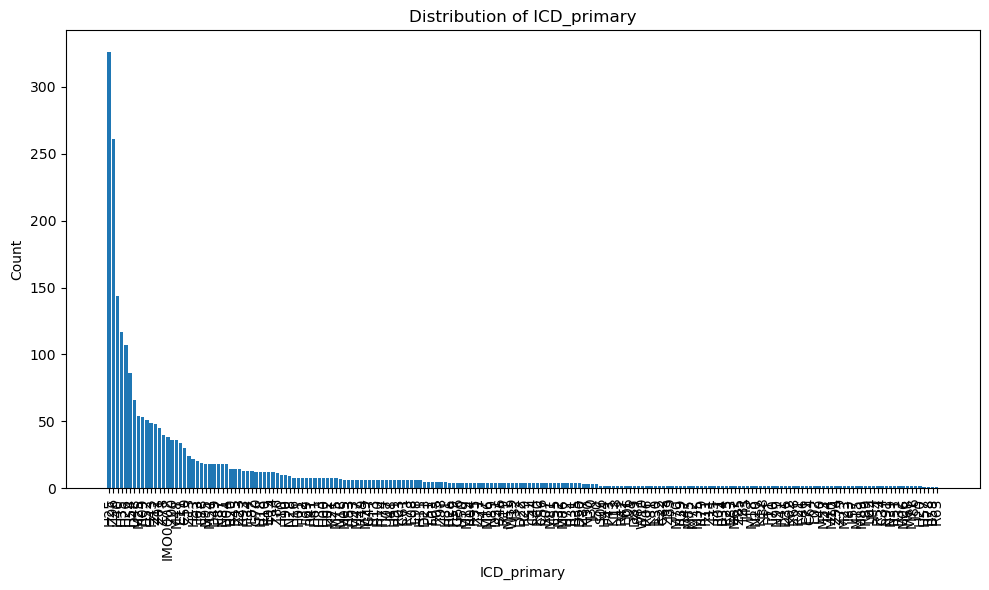

In [ ]:
import matplotlib.pyplot as plt

# calculate icd10 frequency
counts = final_df['ICD_primary'].value_counts()

# bar plot
plt.figure(figsize=(10, 6))
plt.bar(counts.index, counts.values)
plt.xticks(rotation=90)               
plt.title('Distribution of ICD_primary')
plt.xlabel('ICD_primary')
plt.ylabel('Count')
plt.tight_layout()            
plt.show()


## Add Habits

In [ ]:
# 1. prepare sdoh sub-dataframe
sdoh_cols = [
    'CIGARETTES_YN','SMOKING_TOB_USE_NAME','SMOKELESS_TOB_USE_NAME',
    'TOBACCO_USER_NAME','ALCOHOL_USE_NAME','ILL_DRUG_USER_NAME'
]
sdoh_sub = sdoh_df[['PAT_MRN_ID', 'CONTACT_DATE'] + sdoh_cols].copy()
sdoh_sub['CONTACT_DATE'] = pd.to_datetime(sdoh_sub['CONTACT_DATE']) # keep UTC timezone

# 2. convert final_df's visit_date_dt into UTC timezone
final_df['visit_date_dt']   = pd.to_datetime(final_df['visit_date_dt']).dt.tz_localize('UTC')
final_df['orig_idx_sdoh']   = final_df.index

# 3. match by date
exact = final_df.merge(
    sdoh_sub,
    left_on=['research_id', 'visit_date_dt'],
    right_on=['PAT_MRN_ID',  'CONTACT_DATE'],
    how='left',
    suffixes=('','_exact')
)
for col in sdoh_cols:
    final_df[f'{col}_exact'] = exact[col]
final_df['matched_CONTACT_DATE_exact_sdoh'] = exact['CONTACT_DATE']

# 4. if not match, use the closet date
nearest = final_df.merge(
    sdoh_sub,
    left_on=['research_id'],
    right_on=['PAT_MRN_ID'],
    how='left',
    suffixes=('','_nearest')
)
nearest['date_diff_sdoh'] = (nearest['visit_date_dt'] - nearest['CONTACT_DATE']).abs()
closest = (
    nearest
    .sort_values(['orig_idx_sdoh', 'date_diff_sdoh'])
    .groupby('orig_idx_sdoh', as_index=False)
    .first()
)
for col in sdoh_cols:
    final_df[f'{col}_nearest'] = closest.set_index('orig_idx_sdoh')[col]
final_df['matched_CONTACT_DATE_nearest_sdoh'] = closest.set_index('orig_idx_sdoh')['CONTACT_DATE']

# 5. merge dataframe
for col in sdoh_cols:
    final_df[f'{col}_final'] = (
        final_df[f'{col}_exact']
        .fillna(final_df[f'{col}_nearest'])
    )
final_df['matched_CONTACT_DATE_sdoh_final'] = (
    final_df['matched_CONTACT_DATE_exact_sdoh']
    .fillna(final_df['matched_CONTACT_DATE_nearest_sdoh'])
)

# 6. clean support dataframe
drops = [
    'PAT_MRN_ID','orig_idx_sdoh',
    'matched_CONTACT_DATE_exact_sdoh','matched_CONTACT_DATE_nearest_sdoh',
    'date_diff_sdoh'
] + [f'{col}_exact' for col in sdoh_cols] + [f'{col}_nearest' for col in sdoh_cols]
final_df = final_df.drop(columns=[c for c in drops if c in final_df.columns])

# convert datetime
final_df['visit_date_dt'] = (
    pd.to_datetime(final_df['visit_date_dt'])
      .dt.tz_localize(None)  
      .dt.date              
)
final_df['matched_CONTACT_DATE_sdoh_final'] = (
    pd.to_datetime(final_df['matched_CONTACT_DATE_sdoh_final'])
      .dt.tz_localize(None)
      .dt.date
)

# 7. check results
print(final_df[[
    'research_id','visit_date_dt','matched_CONTACT_DATE_sdoh_final'
] + [f'{col}_final' for col in sdoh_cols]].head())
print(len(final_df))

   research_id visit_date_dt matched_CONTACT_DATE_sdoh_final  \
0         3162    2008-08-18                      2008-08-18   
1         3162    2009-08-06                      2008-08-18   
2         3162    2010-08-09                      2009-08-06   
3         3162    2011-08-18                      2010-08-09   
4         3162    2012-09-13                      2011-08-18   

  CIGARETTES_YN_final SMOKING_TOB_USE_NAME_final SMOKELESS_TOB_USE_NAME_final  \
0                   N                      Never                      Unknown   
1                   N                      Never                      Unknown   
2                   N                      Never                      Unknown   
3                   N                      Never                      Unknown   
4                   N                      Never                        Never   

  TOBACCO_USER_NAME_final ALCOHOL_USE_NAME_final ILL_DRUG_USER_NAME_final  
0                   Never                     No    

## Save DF

In [23]:
final_df = final_df.drop(columns=['exact_date_match', 'matched_CONTACT_DATE_dx', 'matched_CONTACT_DATE_sdoh_final'])

In [24]:
print(final_df.columns)

Index(['research_id', 'laterality', 'baseline_stage', 'visit_date',
       'visit_date_dt', 'stage', 'AGE_AT_VISIT', 'SEX', 'VA_continuous',
       'PRIMARY_DX_YN', 'CURRENT_ICD10_LIST', 'ICD_primary',
       'CIGARETTES_YN_final', 'SMOKING_TOB_USE_NAME_final',
       'SMOKELESS_TOB_USE_NAME_final', 'TOBACCO_USER_NAME_final',
       'ALCOHOL_USE_NAME_final', 'ILL_DRUG_USER_NAME_final'],
      dtype='object')


In [25]:
print(final_df.head())

   research_id laterality baseline_stage  visit_date visit_date_dt stage  \
0         3162          L             GA    20080818    2008-08-18    GA   
1         3162          L             GA    20090806    2009-08-06    GA   
2         3162          L             GA    20100809    2010-08-09    GA   
3         3162          L             GA    20110818    2011-08-18    GA   
4         3162          L             GA    20120913    2012-09-13    GA   

   AGE_AT_VISIT     SEX  VA_continuous PRIMARY_DX_YN CURRENT_ICD10_LIST  \
0            65  Female       0.584068             N             H35.81   
1            66  Female       0.584068             N       N18.9, D63.1   
2            67  Female       0.584068             N                Z23   
3            68  Female       0.397940             N              R05.9   
4            69  Female       0.397940             Y              R01.1   

  ICD_primary CIGARETTES_YN_final SMOKING_TOB_USE_NAME_final  \
0         H35               

In [26]:
final_df.to_excel(output_path, index=False)